In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython import display
import numpy as np
import itertools
import time

In [9]:
Nsim = 100;
N = 200;
D = 2;
sigmaMeas = 0.2;
bias = 0.175;

In [10]:
DroneStates = np.zeros((2, Nsim));
measurements = np.zeros(Nsim);
PostParticles = np.zeros((2, N, Nsim));
PriorParticles = np.zeros((2, N));
ParticlesInitial = np.zeros((2, N));
Node = [0,0];
ParticleDist = np.zeros(Nsim);
Particle = np.zeros((2, Nsim));

In [11]:
def MeasureDist(x, y):
    d = np.linalg.norm([x - Node[0], y - Node[1]], axis = 0) + np.random.randint(-1, 2) * bias + sigmaMeas * np.random.randn();
    return d

In [13]:
def MeasureDist2(x, y, i):
    d = np.linalg.norm([x - DroneStates[0, i], y - DroneStates[1, i]], axis = 0);
    return d

In [ ]:
plt.plot(Node[0], Node[1] , 'rX');
rand_y = np.random.uniform(-1, 1, 1);
#rand_change = np.random.uniform(rand_x, rand_x + 4, 1);
rand_direction = np.random.uniform(-10, 10, Nsim);
slope = np.random.uniform(-1, 1, 1);
DroneStates[0, 0] = np.random.uniform(-2, 0);
DroneStates[1, 0] = np.random.uniform(-1, 1)

for i in range(1, Nsim):
    DroneStates[0, i] = 2/Nsim + DroneStates[0, i-1] #line, random or sine
    #DroneStates[1, i] = np.sin(i * np.pi/Nsim) + DroneStates[1, 0]#sine
    #DroneStates[1, i] = rand_direction[i]/Nsim + DroneStates[1, i-1] #randomDroneStates[1, i] = DroneStates[1, i-1]
    #DroneStates[1, i] = DroneStates[1, i-1]
    #DroneStates[1, i] = slope * abs(DroneStates[0, i] - rand_change - 2) + rand_y #v line
    DroneStates[1, i] = slope * 2/Nsim + DroneStates[1, i-1] #line
    measurements[i] = MeasureDist(DroneStates[0, i], DroneStates[1, i]);
PostParticles[0, :, 0] = np.random.uniform(-2, 0, N);
PostParticles[1, :, 0] = np.random.uniform(-1, 1, N);
ParticlesInitial[1, :] = PostParticles[1, :, 0]
ParticlesInitial[0, :] = PostParticles[0, :, 0]

plt.xlim(-2, 2);
plt.ylim(-2, 2);
plt.plot(PostParticles[0, :, 0], PostParticles[1, :, 0], 'g.');
plt.plot(DroneStates[0, :] , DroneStates[1, :], "bx");
plt.grid()


In [ ]:
#x = np.empty();
#y = [];
#x.append(ParticlesInitial[0, :]);
#y.append(ParticlesInitial[1, :]);

#plt.ion();
#figure, ax = plt.subplots(figsize=(10, 8))
#particles, = ax.plot(x, y, 'b.')
#Node = np.random.uniform(-2, 2, 2);

Node = [0, 0];
id_x = [];
id_y = [];
means_x = [];
means_y = [];
K = 0.15;
#for K in range(14, 17):
for L in range(5):
    for i in range(1, Nsim):
        PriorParticles[0, :] = PostParticles[0, :, i-1] + 2/Nsim
        #PriorParticles[1, :] = np.sin(i/Nsim * np.pi) + ParticlesInitial[1, :]; #sine
        #PriorParticles[1, :] = rand_direction[i]/Nsim + PostParticles[1, :, i-1] #random
        PriorParticles[1, :] = slope * 2/Nsim + PostParticles[1, :, i-1] #line
        #PriorParticles[1 ,:] = slope * abs(PriorParticles[0, :] - rand_change - 2) + ParticlesInitial[1,:] #v line
        betas = np.exp(- np.power((measurements[i] - MeasureDist(PriorParticles[0, :], PriorParticles[1, :])), 2)/(2 * sigmaMeas**2));

        betas = betas/sum(betas);
        betaCumSum = np.cumsum(betas);
        
        for j in range(0, N):
            rand = np.random.uniform(0, 1);
            id = np.argwhere(betaCumSum >= rand)[0][0];
            PostParticles[0, j, i] = PriorParticles[0, id]
            PostParticles[1, j, i] = PriorParticles[1, id]
            
        Ei = np.array([[max(PostParticles[0,:,i]) - min(PostParticles[0,:,i])],
                [max(PostParticles[1,:,i]) - min(PostParticles[1,:,i])]]);
        StdRough = K * np.diagflat(Ei) *  1/np.sqrt(N);
        deltaX = np.matmul(StdRough, np.random.randn(2, N));
        PostParticles[:,:,i] = PostParticles[:,:,i] + deltaX;
        #PostParticles[:,:,i] = PriorParticles
        
        plt.xlim(-2, 2);
        plt.ylim(-2, 2);
        plt.grid();
        plt.plot(DroneStates[0, i-1], DroneStates[1, i-1], 'rx')
        plt.plot(PostParticles[0, :, i-1], PostParticles[1, :, i-1], 'b.');
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.cla();
        time.sleep(0.05);
        
    
    means_x.append(np.mean(abs(PostParticles[0, :, Nsim-1] - DroneStates[0, Nsim-1])));
    means_y.append(np.mean(abs(PostParticles[1, :, Nsim-1] - DroneStates[1, Nsim-1])));

    
print("max x difference = ", max(abs(PostParticles[0, :, Nsim-1] - DroneStates[0, Nsim-1])));
print("max y difference = ", max(abs(PostParticles[1, :, Nsim-1] - DroneStates[1, Nsim-1])));
print("min x difference = ", min(abs(PostParticles[0, :, Nsim-1] - DroneStates[0, Nsim-1])));
print("min y difference = ", min(abs(PostParticles[1, :, Nsim-1] - DroneStates[1, Nsim-1])));
print("mean x difference = ", np.mean(abs(PostParticles[0, :, Nsim-1] - DroneStates[0, Nsim-1])));
print("mean y difference = ", np.mean(abs(PostParticles[1, :, Nsim-1] - DroneStates[1, Nsim-1])));
print(np.mean(means_x), np.mean(means_y))
print(np.argwhere(means_x == min(means_x))[0][0], np.argwhere(means_y == min(means_y))[0][0])
#np.argwhere(betas == max(betas))[0][0] 



KeyboardInterrupt: 

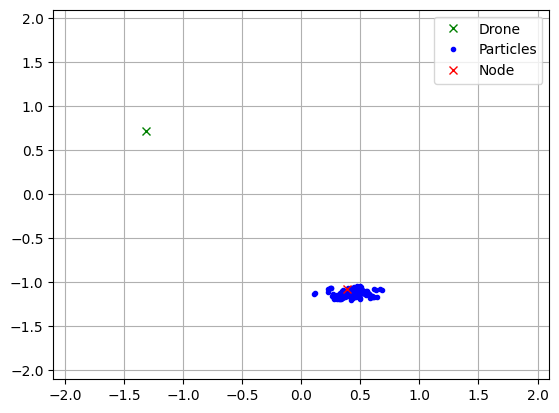

In [58]:
for L in range(1):
    Node = np.random.uniform(-2, 2, 2);
    DroneStates[:, 0] = np.random.uniform(-2, 2, 2);
    #DroneStates[:, 0] = [-2, 0];


    for i in range(1, Nsim):
        DroneStates[0, i] = 1.5 * np.cos(2 * np.pi * i/Nsim);
        DroneStates[1, i] = 1.5 * np.sin(2 * np.pi * i/Nsim);
        #DroneStates[0, i] = 4/Nsim + DroneStates[0, i-1] #line, random or sine
        #DroneStates[1, i] = 1.5 * np.sin(6 * i * np.pi/Nsim) #sine
        #measurements = MeasureDist(DroneStates[0, :], DroneStates[1, :]);
    #DroneStates[1, i] = 2 * rand_direction[i]/Nsim + DroneStates[1, i-1] #random
    #DroneStates[1, i] = 4/Nsim * slope + DroneStates[1, i-1]
    #DroneStates[:, i] = np.random.uniform(-2, 2, 2)

    measurements = MeasureDist(DroneStates[0, :], DroneStates[1, :]);
    
    PostParticles[0, :, 0] = np.random.uniform(-2, 2, N);
    PostParticles[1, :, 0] = np.random.uniform(-2, 2, N);
    ParticlesInitial[1, :] = PostParticles[1, :, 0]
    ParticlesInitial[0, :] = PostParticles[0, :, 0]


    means_x = [];
    means_y = [];
    K = 0.3;
#for K in range(36, 42):
    for i in range(1, Nsim):
        PriorParticles = PostParticles[:, :, i-1]

        betas = np.exp(- np.power(measurements[i] - MeasureDist2(PriorParticles[0, :], PriorParticles[1, :], i), 2)/(2 * sigmaMeas**2));

        betas = betas/sum(betas);
        betaCumSum = np.cumsum(betas);
        
        for j in range(N):
            rand = np.random.uniform(0, 1);
            id = np.argwhere(betaCumSum >= rand)[0][0];
            PostParticles[0, j, i] = PriorParticles[0, id]
            PostParticles[1, j, i] = PriorParticles[1, id]
            
        Ei = np.array([[max(PostParticles[0,:,i]) - min(PostParticles[0,:,i])],
               [max(PostParticles[1,:,i]) - min(PostParticles[1,:,i])]]);
        StdRough = K * np.diagflat(Ei) *  1/np.sqrt(N);
        deltaX = np.matmul(StdRough, np.random.randn(2, N));
        PostParticles[:,:,i] = PostParticles[:,:,i] + deltaX;
        #PostParticles[:,:,i] = PriorParticles
        
        
        plt.xlim(-2.1, 2.1);
        plt.ylim(-2.1, 2.1);
        plt.grid();
        plt.plot(DroneStates[0, i-1], DroneStates[1, i-1], 'gx')
        plt.plot(PostParticles[0, :, i-1], PostParticles[1, :, i-1], 'b.')
        plt.plot(Node[0], Node[1], 'rx')
        plt.legend(["Drone", "Particles", "Node"], loc = 'upper right');
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.cla();
        time.sleep(0.1);
        
    means_x.append(np.mean(PostParticles[0, :, Nsim-1]));
    means_y.append(np.mean(PostParticles[1, :, Nsim-1]));
        
print("Mean error x =", np.mean(means_x - Node[0]),"Mean error y =", np.mean(means_y - Node[1]))
print("Converged to : x =", means_x[len(means_x) - 1],"y =", means_y[len(means_y) - 1])
print("Node coordinates: x =", Node[0], "y =", Node[1])
    

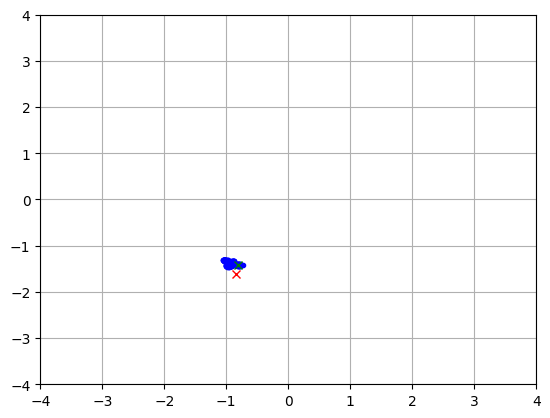

Mean error x = -0.11524767559630622 Mean error y = 0.2424268309657871
Converged to : x = -0.9524699194599192 y = -1.3810946138257634
Node coordinates: x = -0.837222243863613 y = -1.6235214447915505


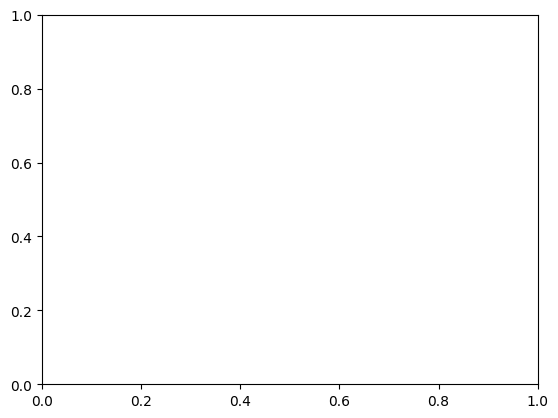

In [59]:
for L in range(1):
    Node = np.random.uniform(-2, 2, 2);
    DroneStates[:, 0] = np.random.uniform(-2, 2, 2);
    
    PostParticles[0, :, 0] = np.random.uniform(-2, 2, N);
    PostParticles[1, :, 0] = np.random.uniform(-2, 2, N);
    ParticlesInitial[1, :] = PostParticles[1, :, 0]
    ParticlesInitial[0, :] = PostParticles[0, :, 0]


    means_x = [];
    means_y = [];
    min_dist_id = 0;
    K = 0.25;
#for K in range(70, 73):
    for i in range(1, Nsim):
        PriorParticles = PostParticles[:, :, i-1];
        if(i == 1):
            DroneStates[:, i] = DroneStates[:, i] + 0.1;
        else:
            DroneStates[:, i] = PriorParticles[:, min_dist_id];
            
        measurements[i] = MeasureDist(DroneStates[0, i], DroneStates[1, i]);
        
        
        betas = np.exp(- np.power(measurements[i] - MeasureDist2(PriorParticles[0, :], PriorParticles[1, :], i), 2)/(2 * sigmaMeas**2));
        min_dist_id = np.argwhere(MeasureDist2(PriorParticles[0, :], PriorParticles[1, :], i) - measurements[i] == min(MeasureDist2(PriorParticles[0, :], PriorParticles[1, :], i) - measurements[i]))[0][0];
        betas = betas/sum(betas);
        betaCumSum = np.cumsum(betas);
        
        
        for j in range(N):
            rand = np.random.uniform(0, 1);
            id = np.argwhere(betaCumSum >= rand)[0][0];
            PostParticles[0, j, i] = PriorParticles[0, id]
            PostParticles[1, j, i] = PriorParticles[1, id]
            
        Ei = np.array([[max(PostParticles[0,:,i]) - min(PostParticles[0,:,i])],
               [max(PostParticles[1,:,i]) - min(PostParticles[1,:,i])]]);
        StdRough = K * np.diagflat(Ei) *  1/np.sqrt(N);
        deltaX = np.matmul(StdRough, np.random.randn(2, N));
        PostParticles[:,:,i] = PostParticles[:,:,i] + deltaX;
        #PostParticles[:,:,i] = PriorParticles
        
        
        plt.xlim(-4, 4);
        plt.ylim(-4, 4);
        plt.grid();
        plt.plot(PostParticles[0, :, i-2], PostParticles[1, :, i-2], 'b.')
        plt.plot(DroneStates[0, i-1], DroneStates[1, i-1], 'gx')
        plt.plot(Node[0], Node[1], 'rx')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.cla();
        time.sleep(0.75);
        
    means_x.append(np.mean(PostParticles[0, :, Nsim-1]));
    means_y.append(np.mean(PostParticles[1, :, Nsim-1]));
        
print("Mean error x =", np.mean(means_x - Node[0]),"Mean error y =", np.mean(means_y - Node[1]))
print("Converged to : x =", means_x[len(means_x) - 1],"y =", means_y[len(means_y) - 1])
print("Node coordinates: x =", Node[0], "y =", Node[1])